# Problem Statement


- How can be best predict the housing prices by deep-cleaning our data? 
- Before fitting various models, what are some important feature engineering steps that can be done for better modeling? 

# EDA

In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [511]:
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [334]:
from scipy import stats  
from sklearn.metrics import r2_score, mean_squared_error 


## Initial inspection

- import data, check shape, investigate data types

In [676]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
train.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [677]:
train.shape

(2051, 81)

In [678]:
test.shape

(878, 80)

In [679]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

## Missing values 
- how many missing values are there? 
- how big is the percentage of the missing data in the columns?

In [312]:
train.isnull().sum().sort_values(ascending=False).head(30)


Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
Overall Cond         0
Exterior 2nd         0
Exterior 1st         0
Roof Matl            0
dtype: int64

In [313]:
train.isnull().mean().sort_values(ascending=False).head(30)


Pool QC           0.995612
Misc Feature      0.968308
Alley             0.931741
Fence             0.804973
Fireplace Qu      0.487567
Lot Frontage      0.160897
Garage Finish     0.055583
Garage Cond       0.055583
Garage Qual       0.055583
Garage Yr Blt     0.055583
Garage Type       0.055095
Bsmt Exposure     0.028279
BsmtFin Type 2    0.027304
BsmtFin Type 1    0.026816
Bsmt Cond         0.026816
Bsmt Qual         0.026816
Mas Vnr Type      0.010726
Mas Vnr Area      0.010726
Bsmt Half Bath    0.000975
Bsmt Full Bath    0.000975
Garage Cars       0.000488
Garage Area       0.000488
Bsmt Unf SF       0.000488
BsmtFin SF 2      0.000488
Total Bsmt SF     0.000488
BsmtFin SF 1      0.000488
Overall Cond      0.000000
Exterior 2nd      0.000000
Exterior 1st      0.000000
Roof Matl         0.000000
dtype: float64

## Distributions

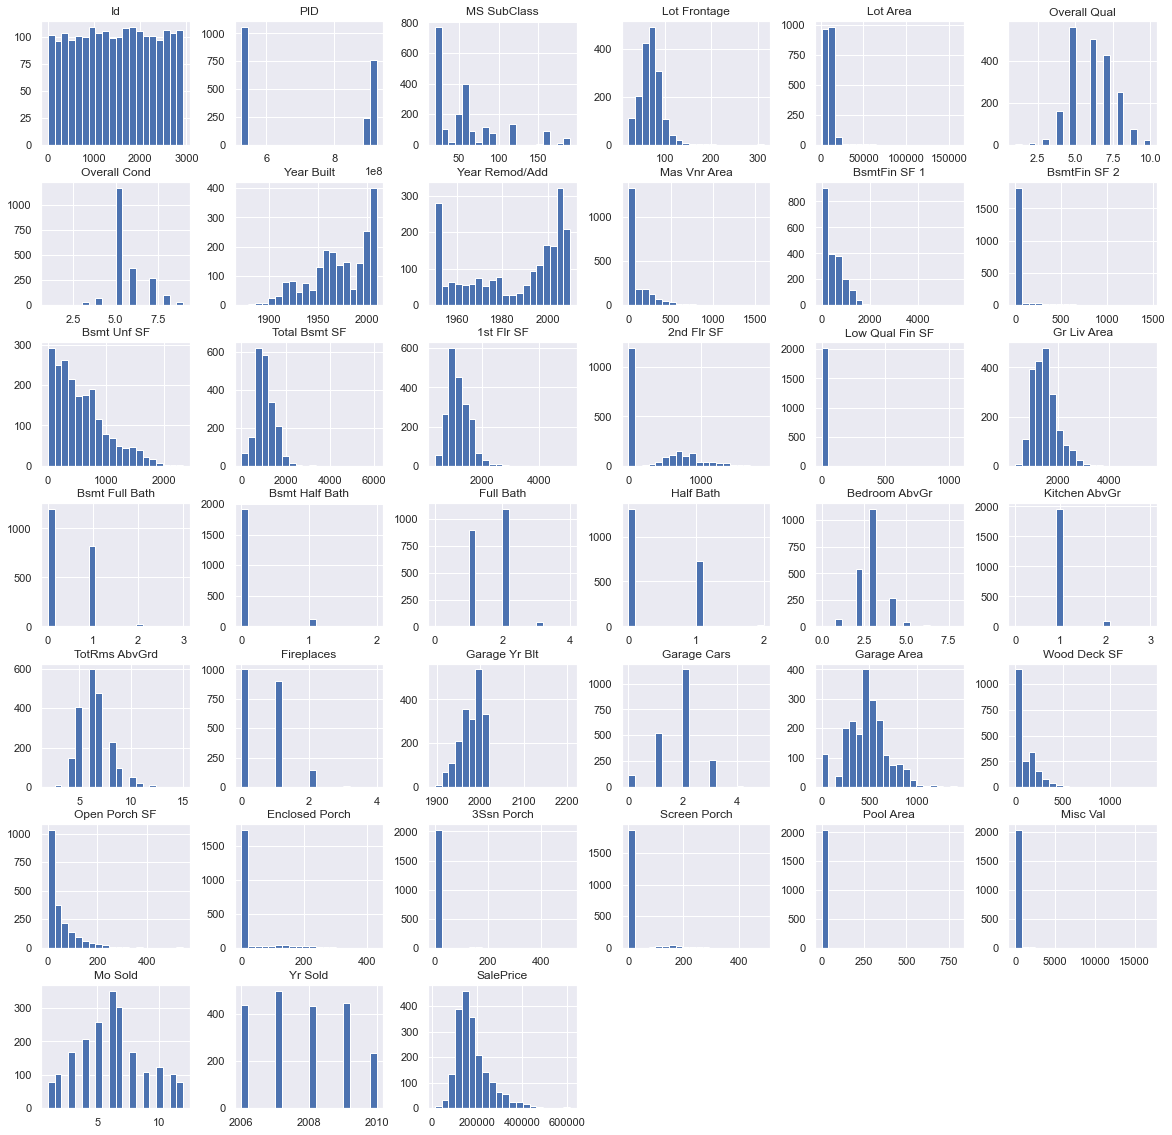

In [680]:
train.hist(figsize=(20,20), bins=20);

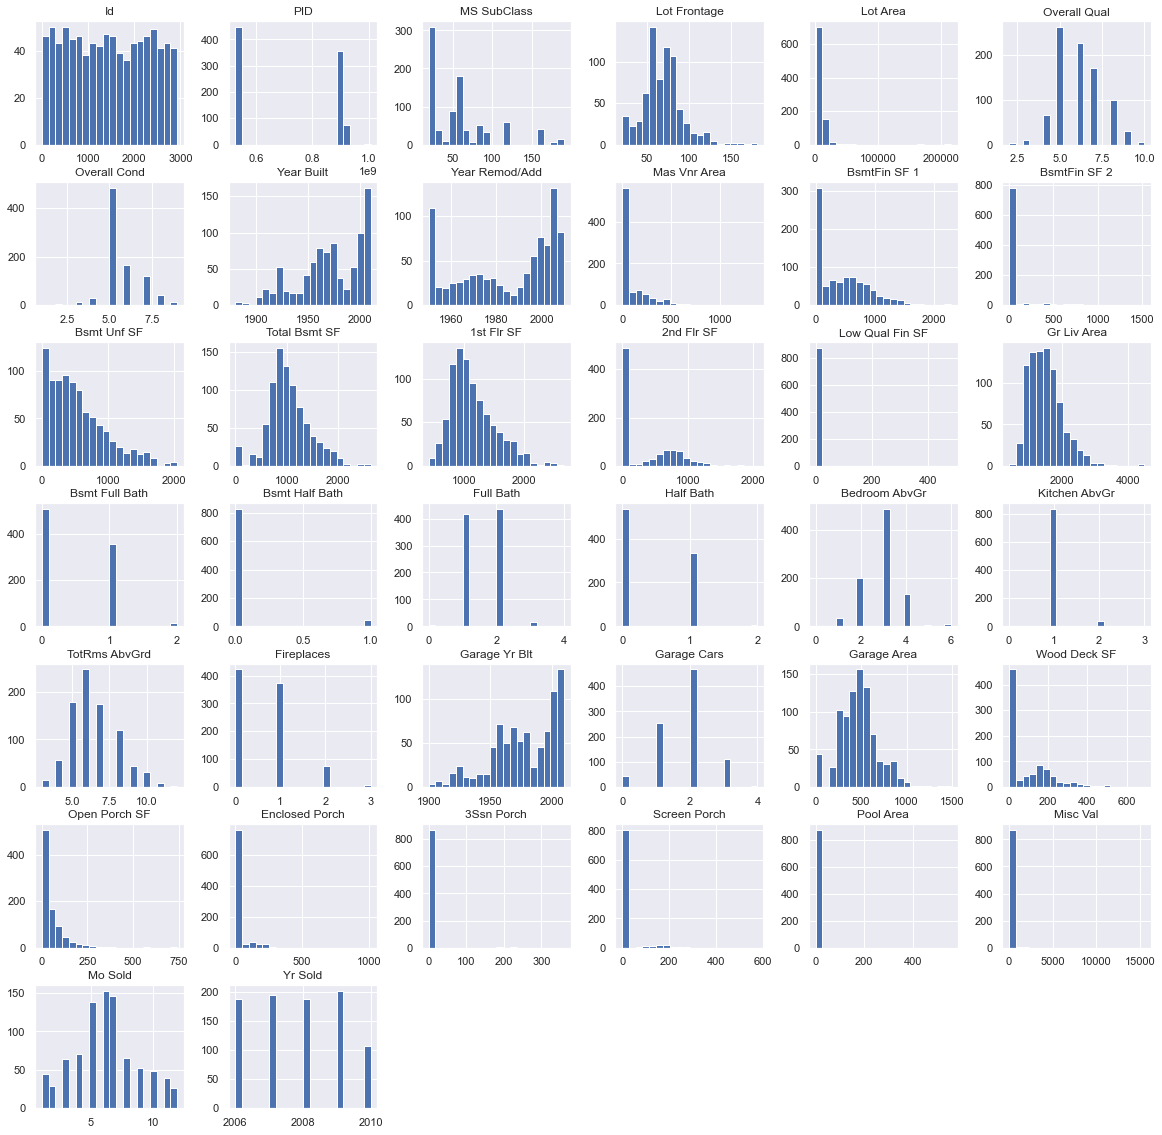

In [681]:
test.hist(figsize=(20,20), bins=20);

- in general, the distribution of the train vs. test looks very comparable with a few exceptions.


## Outliers


- outliers in the train set not present in the test set 
    - lot frontage
    - total bsmt SF
    - 1st fir sf
    - garage yr built
    - wood deck sf
- SalePrice - does not follow standard distribution

In [839]:
train.corr()

Id       PID  MSSubClass  LotFrontage   LotArea  \
Id              1.000000  0.175793    0.026543    -0.024967  0.032872   
PID             0.175793  1.000000   -0.003632    -0.091291  0.024135   
MSSubClass      0.026543 -0.003632    1.000000    -0.389790 -0.245484   
LotFrontage    -0.024967 -0.091291   -0.389790     1.000000  0.574024   
LotArea         0.032872  0.024135   -0.245484     0.574024  1.000000   
OverallQual    -0.061483 -0.265863    0.035763     0.194808  0.105824   
OverallCond    -0.026096  0.106861   -0.070141    -0.054455 -0.019185   
YearBuilt      -0.064444 -0.347039    0.035983     0.109504  0.036002   
YearRemod/Add  -0.090040 -0.176666    0.044836     0.085052  0.050771   
MasVnrArea     -0.035493 -0.247959   -0.004047     0.218218  0.169379   
BsmtFinSF1     -0.045878 -0.086522   -0.060854     0.214178  0.215430   
BsmtFinSF2      0.000723 -0.013144   -0.068265     0.036740  0.041717   
BsmtUnfSF       0.008555 -0.111281   -0.139911     0.127605  0.041184   
TotalBsmtSF    -0.038346 -0.203795   -0.226038     0.356584  0.277175   
1stFlrSF       -0.022650 -0.145862   -0.246212     0.463900  0.381593   
2ndFlrSF       -0.008388 -0.005598    0.305771     0.013700  0.029398   
LowQualFinSF    0.011719  0.072268    0.031091    -0.000300  0.001273   
GrLivArea      -0.023881 -0.112936    0.068210     0.383856  0.327427   
BsmtFullBath   -0.033385 -0.030554    0.025055     0.111441  0.116128   
BsmtHalfBath    0.014381 -0.001946   -0.017249    -0.030858  0.029980   
FullBath       -0.059086 -0.179370    0.142087     0.152812  0.125601   
HalfBath       -0.042054 -0.163975    0.179404     0.035842  0.049995   
BedroomAbvGr    0.010605  0.009122   -0.003516     0.220414  0.139060   
KitchenAbvGr   -0.002400  0.068416    0.252111     0.015856 -0.013484   
TotRmsAbvGrd   -0.009092 -0.084999    0.034490     0.362704  0.238724   
Fireplaces     -0.037560 -0.120710   -0.055118     0.253456  0.289467   
GarageYrBlt    -0.050730 -0.251257    0.084954     0.067865  0.004882   
GarageCars     -0.048666 -0.228368   -0.049148     0.297143  0.214954   
GarageArea     -0.045201 -0.200891   -0.108228     0.358457  0.263296   
WoodDeckSF     -0.009045 -0.041221    0.001622     0.115180  0.155623   
OpenPorchSF     0.001382 -0.081129   -0.020289     0.184958  0.140864   
EnclosedPorch   0.033747  0.150179   -0.039842    -0.003302  0.014139   
3SsnPorch      -0.022791 -0.024679   -0.030088     0.031855  0.019553   
ScreenPorch     0.009758 -0.042030   -0.038819     0.074819  0.067714   
PoolArea        0.055696  0.005825   -0.004585     0.156575  0.115102   
MiscVal        -0.012683  0.004223   -0.027485     0.051676  0.093922   
MoSold          0.127723 -0.032735    0.013027    -0.017389  0.003197   
YrSold         -0.975747  0.008476   -0.032870     0.009112 -0.029454   
SalePrice      -0.051398 -0.255052   -0.087335     0.341842  0.296566   
SalePrice_norm -0.046616 -0.269126   -0.069966     0.334414  0.279942   

                OverallQual  OverallCond  YearBuilt  YearRemod/Add  \
Id                -0.061483    -0.026096  -0.064444      -0.090040   
PID               -0.265863     0.106861  -0.347039      -0.176666   
MSSubClass         0.035763    -0.070141   0.035983       0.044836   
LotFrontage        0.194808    -0.054455   0.109504       0.085052   
LotArea            0.105824    -0.019185   0.036002       0.050771   
OverallQual        1.000000    -0.082770   0.602964       0.584654   
OverallCond       -0.082770     1.000000  -0.370988       0.042614   
YearBuilt          0.602964    -0.370988   1.000000       0.629116   
YearRemod/Add      0.584654     0.042614   0.629116       1.000000   
MasVnrArea         0.438685    -0.135878   0.329741       0.211443   
BsmtFinSF1         0.278742    -0.045768   0.275440       0.166680   
BsmtFinSF2        -0.028199     0.047810  -0.021031      -0.057163   
BsmtUnfSF          0.275773    -0.130521   0.136662       0.160066   
TotalBsmtSF        0.548742    -0.158643   0.410

In [840]:
numeric_col = train._get_numeric_data().columns
numeric_train = train[numeric_col]
numeric_col_list = list(numeric_train.columns)
    

In [841]:
train[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(50)


SalePrice         1.000000
SalePrice_norm    0.946134
OverallQual       0.800207
GrLivArea         0.697038
GarageArea        0.650270
GarageCars        0.648220
TotalBsmtSF       0.628925
1stFlrSF          0.618486
YearBuilt         0.571849
YearRemod/Add     0.550370
FullBath          0.537969
GarageYrBlt       0.533922
MasVnrArea        0.512230
TotRmsAbvGrd      0.504014
Fireplaces        0.471093
BsmtFinSF1        0.423519
LotFrontage       0.341842
OpenPorchSF       0.333476
WoodDeckSF        0.326490
LotArea           0.296566
BsmtFullBath      0.283662
HalfBath          0.283001
2ndFlrSF          0.248452
BsmtUnfSF         0.190210
BedroomAbvGr      0.137067
ScreenPorch       0.134581
3SsnPorch         0.048732
MoSold            0.032735
PoolArea          0.023106
BsmtFinSF2        0.016255
MiscVal          -0.007375
YrSold           -0.015203
LowQualFinSF     -0.041594
BsmtHalfBath     -0.045328
Id               -0.051398
MSSubClass       -0.087335
OverallCond      -0.097019
K

In [685]:
top20corr = train[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(21)
top20corr = top20corr.iloc[1:]
top20corr.index

Index(['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage', 'Open Porch SF',
       'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath', 'Half Bath'],
      dtype='object')

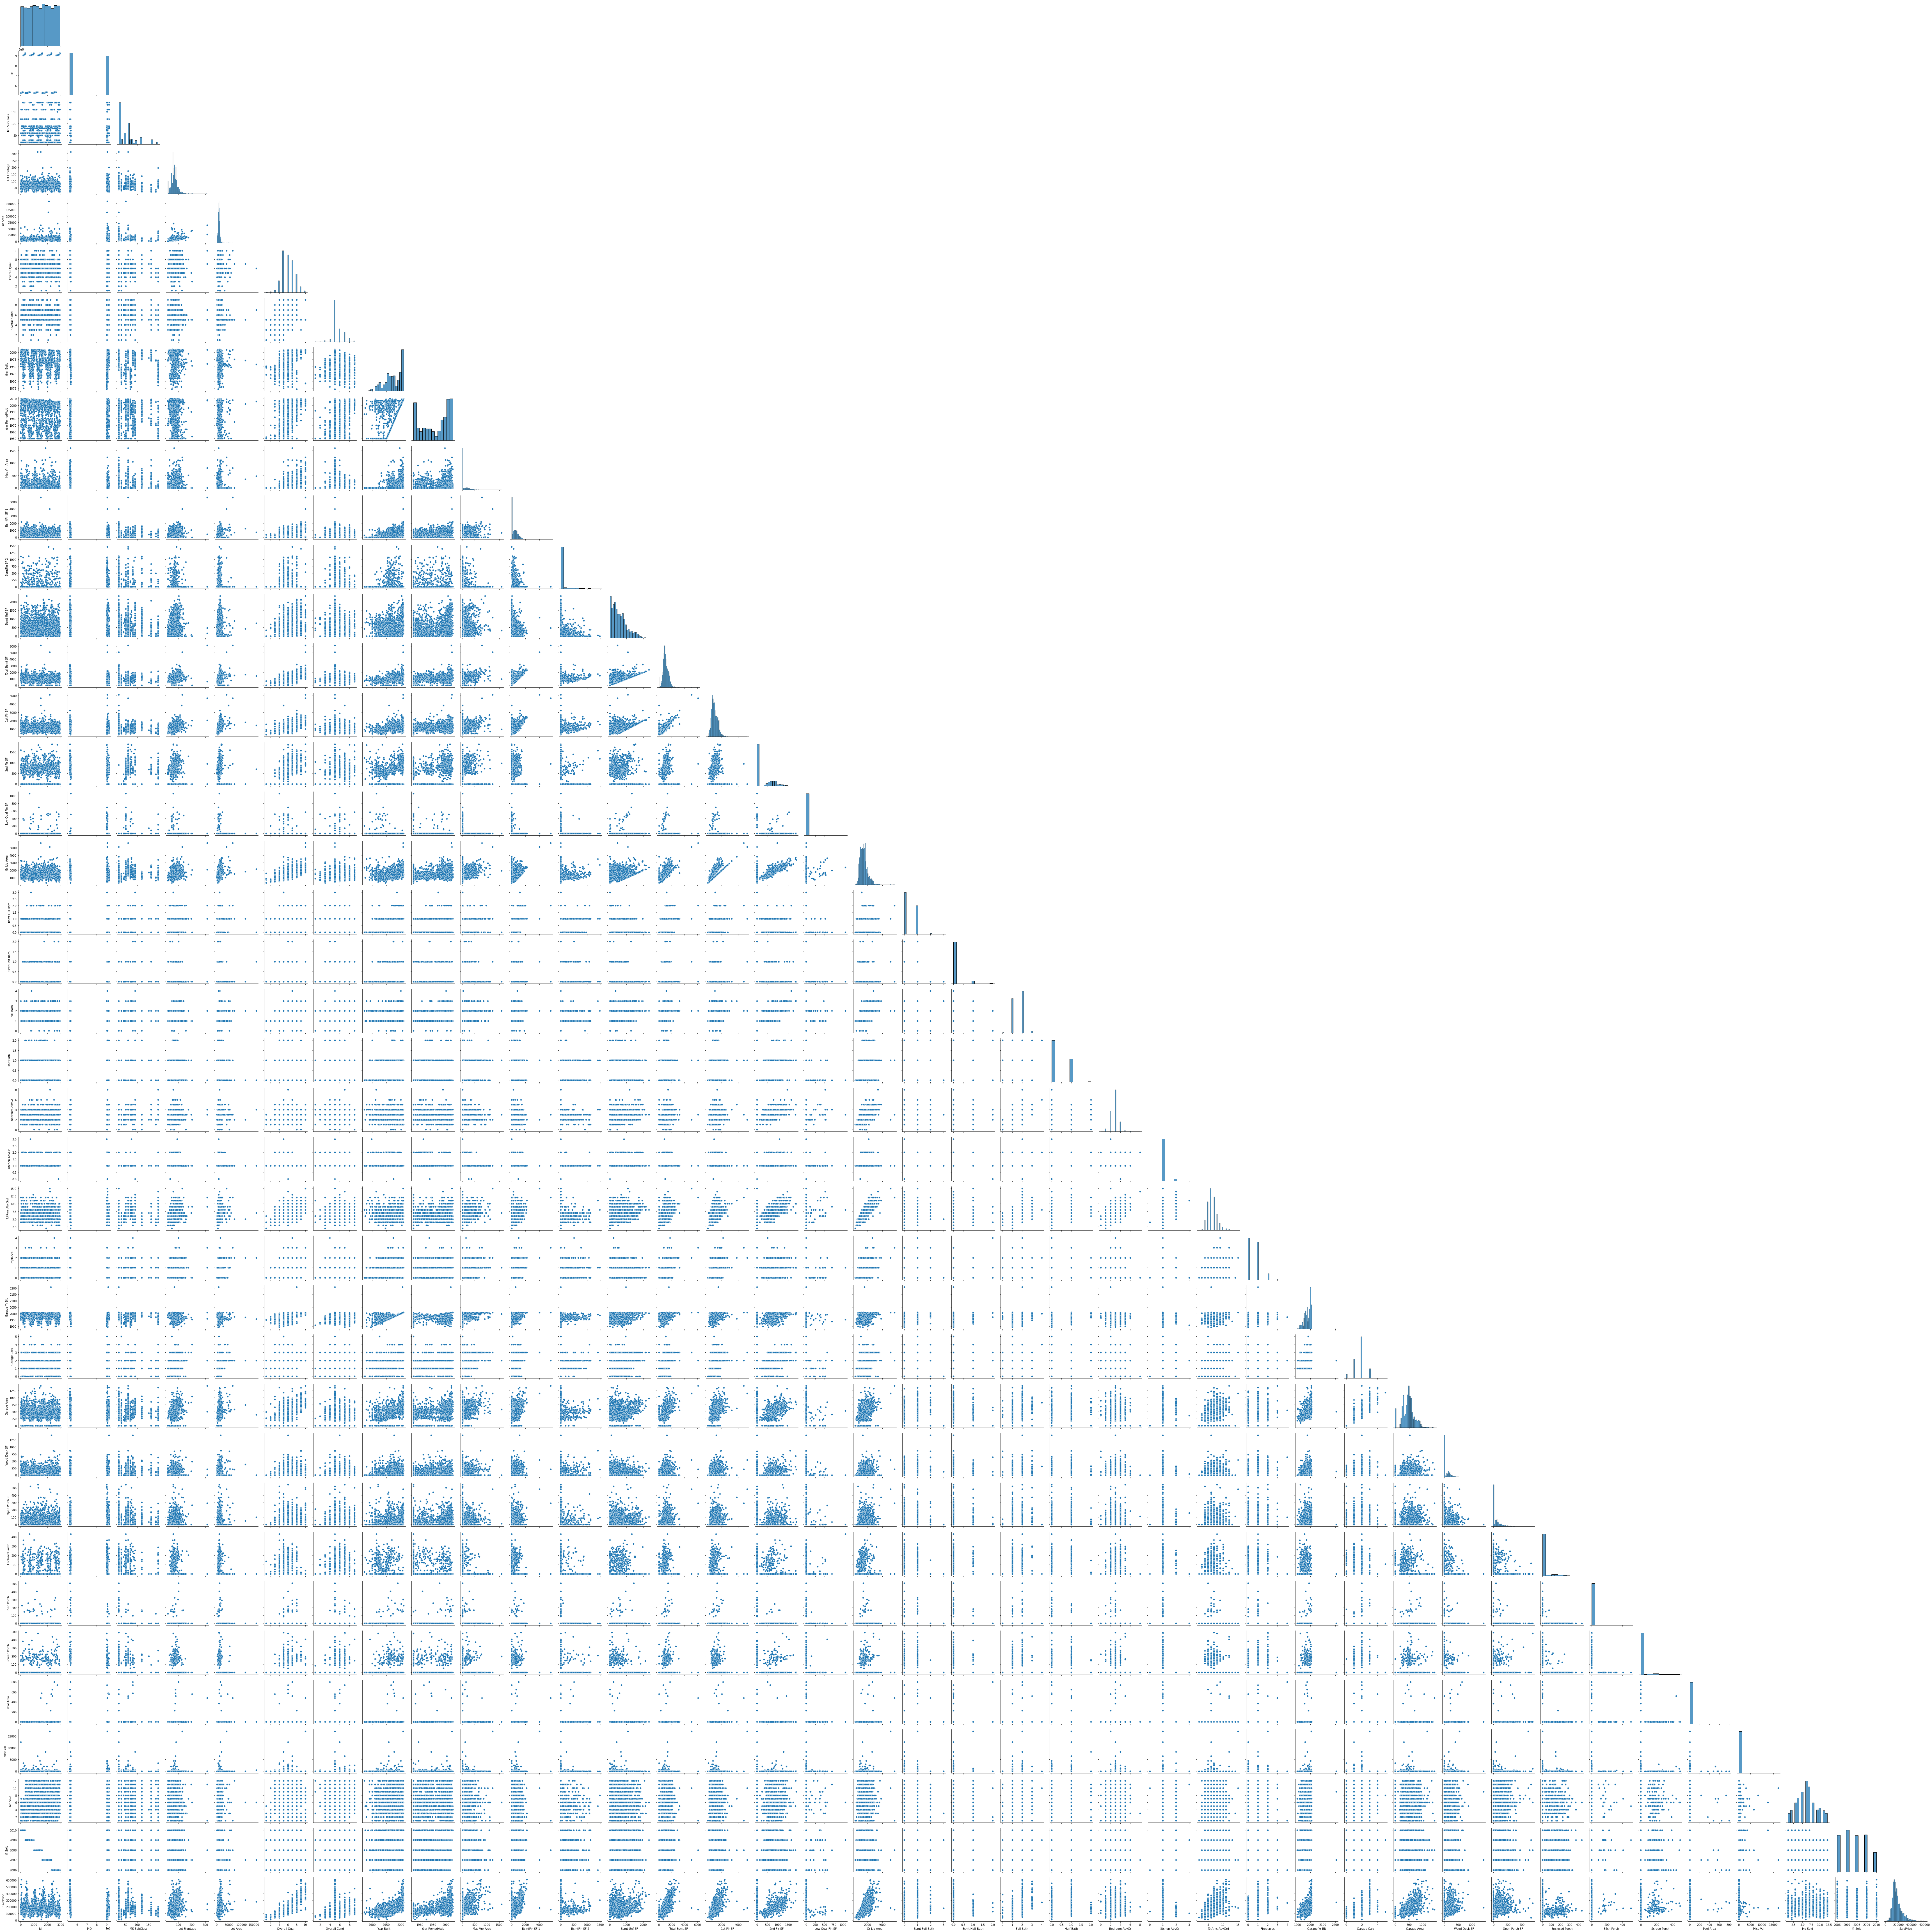

In [1201]:
# Show the results of a linear regression within each dataset
sns.pairplot(numeric_train, corner=True);

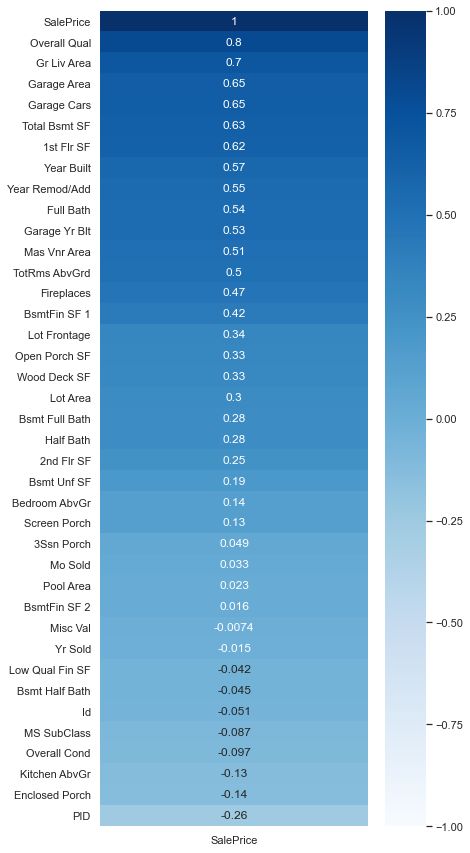

In [322]:
# adapted from Adi's Feature Engineering solutionsfig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.figure(figsize=(6,15))
sns.heatmap(numeric_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False),
           annot=True,
           vmin=-1, vmax=1,
           cmap='Blues');

<AxesSubplot:>

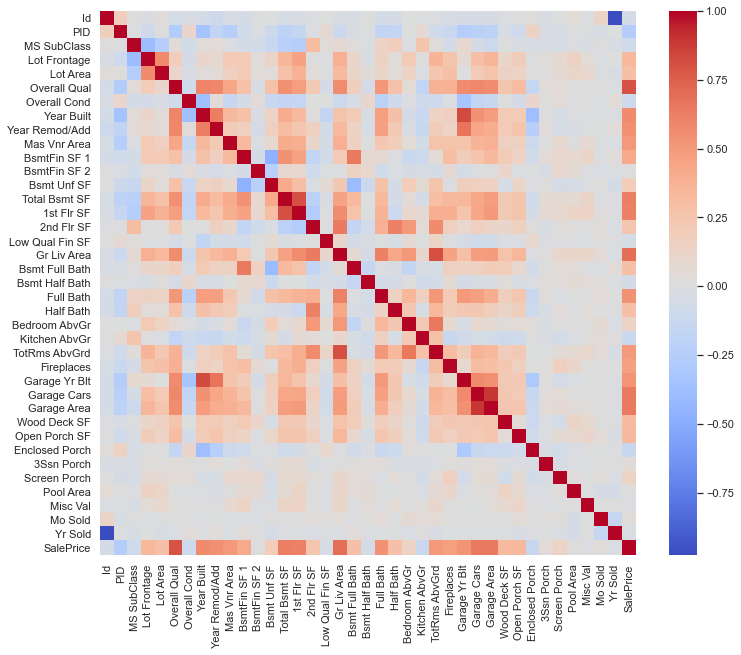

In [1308]:

plt.subplots(figsize=(12,10))
sns.heatmap(train.corr(), cmap="coolwarm")

## Summary statistics

In [843]:
train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [842]:
test.describe()

Id           PID  MSSubClass  LotFrontage        LotArea  \
count   878.000000  8.780000e+02  878.000000   718.000000     878.000000   
mean   1444.749431  7.162867e+08   58.268793    69.545961   10307.033030   
std     850.838263  1.889103e+08   42.235407    23.533945   10002.674602   
min       2.000000  5.263021e+08   20.000000    21.000000    1477.000000   
25%     692.250000  5.284841e+08   20.000000    59.000000    7297.250000   
50%    1433.000000  5.354542e+08   50.000000    68.000000    9446.000000   
75%    2197.500000  9.071904e+08   70.000000    80.000000   11589.000000   
max    2928.000000  1.007100e+09  190.000000   182.000000  215245.000000   

       OverallQual  OverallCond    YearBuilt  YearRemod/Add   MasVnrArea  ...  \
count   878.000000   878.000000   878.000000     878.000000   877.000000  ...   
mean      6.050114     5.566059  1970.492027    1984.417995   106.236032  ...   
std       1.369065     1.128903    30.395895      20.450725   187.158908  ...   
min       2.000000     1.000000  1880.000000    1950.000000     0.000000  ...   
25%       5.000000     5.000000  1954.000000    1967.000000     0.000000  ...   
50%       6.000000     5.000000  1972.000000    1992.000000     0.000000  ...   
75%       7.000000     6.000000  1999.750000    2003.000000   172.000000  ...   
max      10.000000     9.000000  2010.000000    2010.000000  1378.000000  ...   

        GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch   3SsnPorch  \
count   878.000000  878.000000   878.000000     878.000000  878.000000   
mean    470.362187   93.430524    47.070615      24.064920    2.597950   
std     212.734075  121.181702    68.180939      73.249463   24.962482   
min       0.000000    0.000000     0.000000       0.000000    0.000000   
25%     322.500000    0.000000     0.000000       0.000000    0.000000   
50%     473.000000    0.000000    27.000000       0.000000    0.000000   
75%     576.000000  170.750000    69.750000       0.000000    0.000000   
max    1488.000000  690.000000   742.000000    1012.000000  360.000000   

       ScreenPorch    PoolArea       MiscVal      MoSold       YrSold  
count   878.000000  878.000000    878.000000  878.000000   878.000000  
mean     14.830296    1.884966     48.498861    6.202733  2007.825740  
std      53.003794   29.916672    550.169317    2.642498     1.327861  
min       0.000000    0.000000      0.000000    1.000000  2006.000000  
25%       0.000000    0.000000      0.000000    5.000000  2007.000000  
50%       0.000000    0.000000      0.000000    6.000000  2008.000000  
75%       0.000000    0.000000      0.000000    8.000000  2009.000000  
max     576.000000  555.000000  15500.000000   12.000000  2010.000000  

[8 rows x 38 columns]

## Modeling insights to investigate

- about 50% of features are categorical
- some distributions are heavily skewed/kurt, which can negatively affect regression model
- there are many missing values - too many to drop & lose other valuable information. 

# Preliminary LR Model Fitting and Evaluation

## using All non-Numeric Columns as OneHot

### set X and Y
### Fit the model

In [844]:
df = train
features = [col for col in df.columns if col not in numeric_col]
X = df[features]
X = pd.get_dummies(data=X, drop_first=True, columns=features)
y = df['SalePrice']
lr_all_dummies = LinearRegression()
lr_all_dummies.fit(X,y)
X.shape

(2051, 211)

### R2 

In [845]:
# X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, train_size=0.8, random_state=42)
y_pred = lr_all_dummies.predict(X)

r2_score(y,y_pred)

0.8611506066336391

### RMSE

In [846]:
mean_squared_error(y,y_pred, squared=False)

29526.557511360512

### train/test/split

In [847]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [848]:
linreg1 = LinearRegression()

In [849]:
linreg1.fit(X_train, y_train)

LinearRegression()

In [850]:
train_preds = linreg1.predict(X_train)
test_preds = linreg1.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

29098.259002446022

In [695]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

427047977228793.44

## using Top 20 Correlated Numeric Columns


### Filter out Top 20 most highly correlated numeric columns

In [851]:
top20corr = df[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(21)
top20corr = top20corr.iloc[1:]
top20corr.index

Index(['SalePrice_norm', 'OverallQual', 'GrLivArea', 'GarageArea',
       'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemod/Add',
       'FullBath', 'GarageYrBlt', 'MasVnrArea', 'TotRmsAbvGrd', 'Fireplaces',
       'BsmtFinSF1', 'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', 'LotArea',
       'BsmtFullBath'],
      dtype='object')

### X, Y, fit, predict

In [852]:
features = top20corr.index
X = df[features]

In [853]:
X.fillna(0, inplace=True)
X.isnull().sum()

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


SalePrice_norm    0
OverallQual       0
GrLivArea         0
GarageArea        0
GarageCars        0
TotalBsmtSF       0
1stFlrSF          0
YearBuilt         0
YearRemod/Add     0
FullBath          0
GarageYrBlt       0
MasVnrArea        0
TotRmsAbvGrd      0
Fireplaces        0
BsmtFinSF1        0
LotFrontage       0
OpenPorchSF       0
WoodDeckSF        0
LotArea           0
BsmtFullBath      0
dtype: int64

In [854]:
y = df['SalePrice']
lr_top20corr = LinearRegression()
lr_top20corr.fit(X,y)
y_pred = lr_top20corr.predict(X)
X.shape

(2051, 20)

### R2

In [700]:

r2_score(y,y_pred)

0.8166005133100932

### RMSE

In [701]:
# RMSE for testing
mean_squared_error(y, y_pred, squared=False)

33934.37699064142

### train/test/split

In [702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [703]:
linreg2 = LinearRegression()

In [704]:
linreg2.fit(X_train, y_train)

LinearRegression()

In [705]:
train_preds = linreg2.predict(X_train)
test_preds = linreg2.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

35196.52502880836

In [706]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

28947.921868985322

## using Top 10 Correlated Numeric Columns


### Filter out Top 10 most highly correlated numeric columns

In [707]:
top10corr = df[numeric_col].corr()['SalePrice'][:].sort_values(ascending=False).head(11)
top10corr = top10corr.iloc[1:]
top10corr.index

Index(['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add',
       'Full Bath', 'Garage Yr Blt'],
      dtype='object')

### X, Y, fit, predict

In [708]:
features = top10corr.index
X = df[features]
X.fillna(0, inplace=True)
y = df['SalePrice']
lr_top10corr = LinearRegression()
lr_top10corr.fit(X,y)
y_pred = lr_top10corr.predict(X)
X.shape


/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


(2051, 10)

### R2

In [709]:

r2_score(y,y_pred)

0.7940322907659216

### RMSE

In [710]:
# RMSE for testing
mean_squared_error(y, y_pred, squared=False)

35961.71474334274

### train/test/split

In [711]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [712]:
linreg2_10 = LinearRegression()

In [713]:
linreg2_10.fit(X_train, y_train)

LinearRegression()

In [714]:
train_preds = linreg2_10.predict(X_train)
test_preds = linreg2_10.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

37204.30190652285

In [715]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

30659.92537425666

## using all numeric columns

In [716]:
features = [col for col in df.columns if col in numeric_col and col != 'SalePrice']
X = df[features]
X.fillna(0, inplace=True)
y = df['SalePrice']
lr_allnum = LinearRegression()
lr_allnum.fit(X,y)
y_pred = lr_allnum.predict(X)
X.shape

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


(2051, 38)

### R2

In [717]:

r2_score(y,y_pred)

0.8410808671827921

### RMSE

In [718]:
# RMSE for testing
mean_squared_error(y, y_pred, squared=False)

31588.4936001837

### train/test/split

In [719]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [720]:
linreg3 = LinearRegression()

In [721]:
linreg3.fit(X_train, y_train)

LinearRegression()

In [722]:
train_preds = linreg3.predict(X_train)
test_preds = linreg3.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

32555.258229598825

In [723]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

28112.02163162659

## Using All numeric columns with dummies

In [724]:
# Getting dummy variables with the other numerical columns
X = df.drop(columns='SalePrice')
X.isnull().sum().sort_values(ascending=False).head(20)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Yr Blt      114
Garage Cond        114
Garage Qual        114
Garage Finish      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
BsmtFin Type 1      55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
dtype: int64

In [725]:
X.drop(columns=['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'], inplace=True)

In [838]:
median = X['Lot Frontage'].median()
X['Lot Frontage'] = X['Lot Frontage'].fillna(median, inplace=True)
X.fillna(0, inplace=True)
X.isnull().sum().sort_values(ascending=False).head()

KeyError: 'Lot Frontage'

In [727]:
y = df['SalePrice']
X_dummy = pd.get_dummies(X, columns=[col for col in df.columns if col not in numeric_col], drop_first=True)
lr_allcol = LinearRegression()
lr_allcol.fit(X_dummy,y)
y_pred = lr_allcol.predict(X_dummy)
X_dummy.shape

KeyError: "['Misc Feature', 'Alley', 'Pool QC', 'Fireplace Qu', 'Fence'] not in index"

### R2

In [ ]:

r2_score(y,y_pred)

### RMSE

In [ ]:
# RMSE for testing
mean_squared_error(y, y_pred, squared=False)

### train/test/split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, train_size=0.8, random_state=42)

In [ ]:
linreg4 = LinearRegression()

In [ ]:
linreg4.fit(X_train, y_train)

In [ ]:
train_preds = linreg4.predict(X_train)
test_preds = linreg4.predict(X_test)
mean_squared_error(y_true=y_train, y_pred=train_preds, squared=False)

In [ ]:
mean_squared_error(y_true=y_test, y_pred=test_preds, squared=False)

In [ ]:
X.to_csv('rough_clean_df')

# Deep Cleaning & Feature Engineering

In [855]:
train.columns = train.columns.str.replace(' ', '')
test.columns = test.columns.str.replace(' ', '')

## Right-skewed SalePrice distribution

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'SalePrice Histogram')]

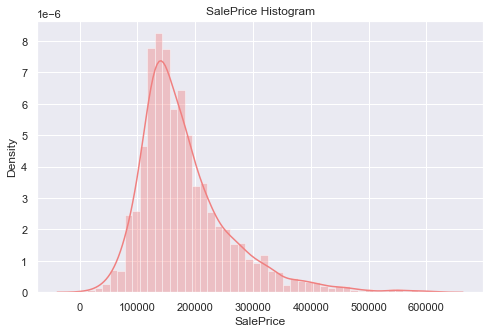

In [856]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(train['SalePrice'], color="lightcoral");
ax.set(title="SalePrice Histogram")


In [857]:
# a quick research shows a few tricks to deal with right-skewed distributions 
# https://rcompanion.org/handbook/I_12.html#:~:text=For%20right%2Dskewed%20data%E2%80%94tail,log%20(constant%20%E2%80%93%20x

train_saleprice_sqrt = np.sqrt(train['SalePrice'])
train_saleprice_cbrt = np.cbrt(train['SalePrice'])
train_saleprice_log = np.log(train['SalePrice'])



In [729]:
stats.skew(train['SalePrice'])


1.5564120909746169

In [730]:
stats.skew(train_saleprice_sqrt)


0.7862294064717241

In [731]:
stats.skew(train_saleprice_log)


-0.14670836711063925

(417.0644190473226, 86.75812338732638)


/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


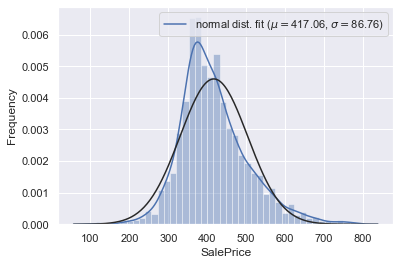

In [858]:
# graphing adapted from https://stackoverflow.com/questions/31413934/howto-get-fit-parameters-from-seaborn-distplot-fit

sns.distplot(train_saleprice_sqrt, fit=stats.norm);
print(stats.norm.fit(train_saleprice_sqrt))

(mu, sigma) = stats.norm.fit(train_saleprice_sqrt)
# Legend and labels 
plt.legend(["normal dist. fit ($\mu=${0:.2f}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.ylabel('Frequency');

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(55.56137424840189, 7.636249844222816)


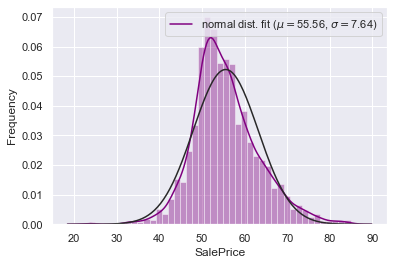

In [733]:
sns.distplot(train_saleprice_cbrt, fit=stats.norm, color='purple');
print(stats.norm.fit(train_saleprice_cbrt))

(mu, sigma) = stats.norm.fit(train_saleprice_cbrt)
# print(stats.norm.fit(train_saleprice_sqrt))
# Legend and labels 
plt.legend(["normal dist. fit ($\mu=${0:.2f}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.ylabel('Frequency');

(12.024396927855069, 0.4112161317472311)


/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


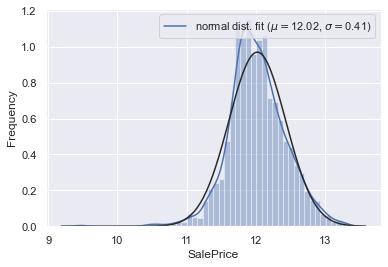

In [734]:
sns.distplot(train_saleprice_log, fit=stats.norm)
print(stats.norm.fit(train_saleprice_log))
(mu, sigma) = stats.norm.fit(train_saleprice_log)
# print(stats.norm.fit(train_saleprice_sqrt))
# Legend and labels 
plt.legend(["normal dist. fit ($\mu=${0:.2f}, $\sigma=${1:.2f})".format(mu, sigma)])
plt.ylabel('Frequency');

In [735]:
train.shape

(2051, 81)

In [859]:
train['SalePrice_norm'] = np.log(train['SalePrice'])
train['SalePrice_norm']

0       11.779129
1       12.301383
2       11.599103
3       12.066811
4       11.838626
          ...    
2046    12.607366
2047    11.320554
2048    12.083905
2049    11.877569
2050    12.149502
Name: SalePrice_norm, Length: 2051, dtype: float64

In [860]:
train_norm = train.copy()
train_norm.head()
train_norm.shape

(2051, 82)

## Eliminate outliers

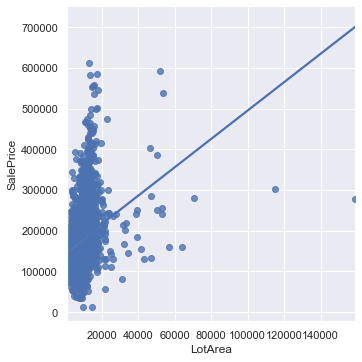

In [756]:
sns.lmplot(y = 'SalePrice', x = 'LotArea', data = train_norm, ci = False);

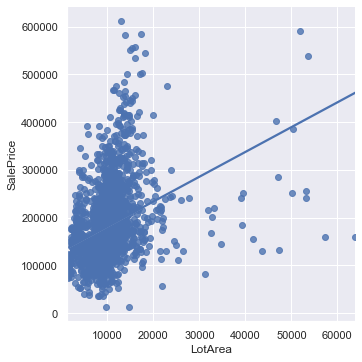

In [861]:
train_norm.drop(train_norm[(train_norm['LotArea']> train_norm['LotArea'].quantile(0.999))].index, inplace=True)

sns.lmplot(y = 'SalePrice', x = 'LotArea', data = train_norm, ci = False);

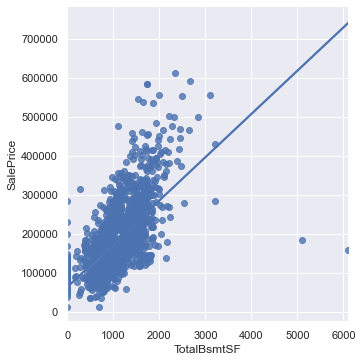

In [758]:
sns.lmplot(y = 'SalePrice', x = 'TotalBsmtSF', data = train_norm, ci = False);

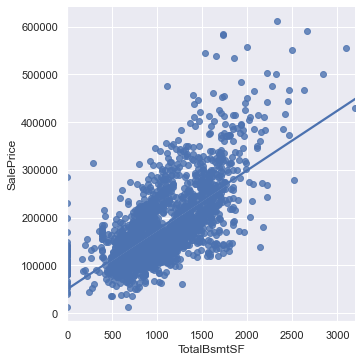

In [862]:
train_norm.drop(train_norm[(train_norm['TotalBsmtSF']> train_norm['TotalBsmtSF'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = 'TotalBsmtSF', data = train_norm, ci = False);

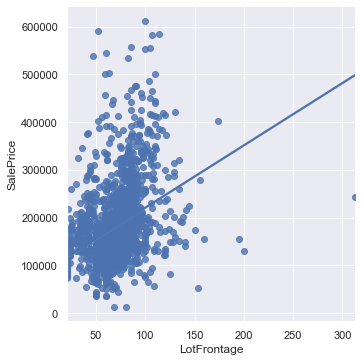

In [760]:
sns.lmplot(y = 'SalePrice', x = 'LotFrontage', data = train_norm, ci = False);

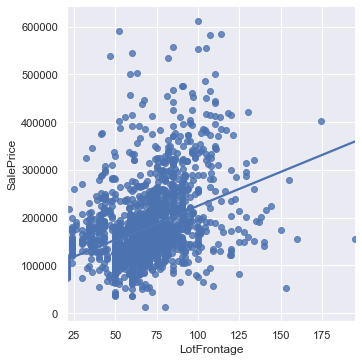

In [863]:
train_norm.drop(train_norm[(train_norm['LotFrontage']> train_norm['LotFrontage'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = 'LotFrontage', data = train_norm, ci = False);

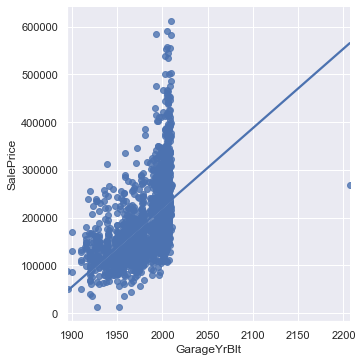

In [762]:

sns.lmplot(y = 'SalePrice', x = 'GarageYrBlt', data = train_norm, ci = False);


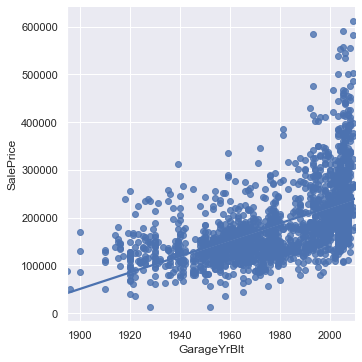

In [864]:
train_norm.drop(train_norm[(train_norm['GarageYrBlt']> 2020)].index, inplace=True)

sns.lmplot(y = 'SalePrice', x = 'GarageYrBlt', data = train_norm, ci = False);


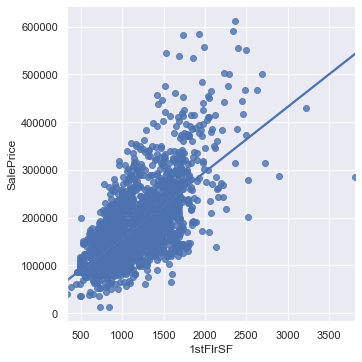

In [764]:
sns.lmplot(y = 'SalePrice', x = '1stFlrSF', data = train_norm, ci = False);

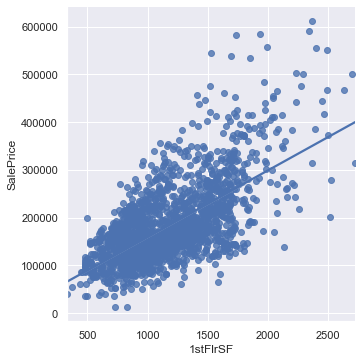

In [865]:
train_norm.drop(train_norm[(train_norm['1stFlrSF']> train_norm['1stFlrSF'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = '1stFlrSF', data = train_norm, ci = False);

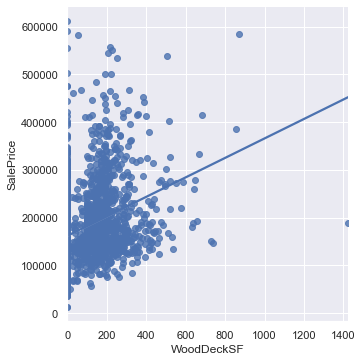

In [766]:

sns.lmplot(y = 'SalePrice', x = 'WoodDeckSF', data = train_norm, ci = False);

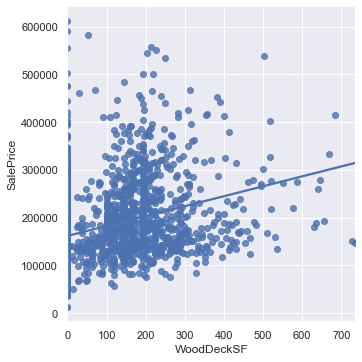

In [866]:
train_norm.drop(train_norm[(train_norm['WoodDeckSF']> train_norm['WoodDeckSF'].quantile(0.999))].index, inplace=True)
sns.lmplot(y = 'SalePrice', x = 'WoodDeckSF', data = train_norm, ci = False);

In [899]:
train_nr_out = train_norm.copy()
train_nr_out.to_csv('train_norm.csv')
train_nr_out.shape

(2036, 82)

## Correct Skewness for all features

In [868]:
big_df = pd.concat([train_nr_out, test], axis=0)
big_df.reset_index(inplace=True)
big_df.columns

Index(['index', 'Id', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageC

In [869]:
big_df.drop(columns=['index', 'Id', 'PID', 'Street', 'Alley', 'MiscFeature', 'Utilities', 'Fence', 'PoolQC'], axis=1, inplace=True)
big_df.head()

MSSubClass MSZoning  LotFrontage  LotArea LotShape LandContour LotConfig  \
0          60       RL          NaN    13517      IR1         Lvl   CulDSac   
1          60       RL         43.0    11492      IR1         Lvl   CulDSac   
2          20       RL         68.0     7922      Reg         Lvl    Inside   
3          60       RL         73.0     9802      Reg         Lvl    Inside   
4          50       RL         82.0    14235      IR1         Lvl    Inside   

  LandSlope Neighborhood Condition1  ... EnclosedPorch 3SsnPorch ScreenPorch  \
0       Gtl       Sawyer       RRAe  ...             0         0           0   
1       Gtl      SawyerW       Norm  ...             0         0           0   
2       Gtl        NAmes       Norm  ...             0         0           0   
3       Gtl       Timber       Norm  ...             0         0           0   
4       Gtl      SawyerW       Norm  ...             0         0           0   

   PoolArea  MiscVal  MoSold  YrSold SaleType SalePrice SalePrice_norm  
0         0        0       3    2010      WD   130500.0      11.779129  
1         0        0       4    2009      WD   220000.0      12.301383  
2         0        0       1    2010      WD   109000.0      11.599103  
3         0        0       4    2010      WD   174000.0      12.066811  
4         0        0       3    2010      WD   138500.0      11.838626  

[5 rows x 74 columns]

In [870]:
X = big_df.drop(columns=['SalePrice', 'SalePrice_norm'], axis=1)
y = big_df['SalePrice_norm']

In [871]:
X.isnull().sum().sort_values(ascending=False).head(30)

FireplaceQu     1421
LotFrontage      485
GarageFinish     159
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageType       157
BsmtExposure      81
BsmtQual          78
BsmtCond          78
BsmtFinType1      78
BsmtFinType2      78
MasVnrType        22
MasVnrArea        22
Electrical         1
GarageCars         1
BsmtFullBath       1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
BsmtHalfBath       1
ExterCond          0
ExterQual          0
Exterior2nd        0
Exterior1st        0
RoofMatl           0
SaleType           0
RoofStyle          0
dtype: int64

In [872]:

fill_none = ['GarageFinish', 'FireplaceQu', 'GarageQual', 'GarageCond','GarageType', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtCond', 'MasVnrType']
for col in fill_none:
    big_df[col] = big_df[col].fillna("None")


In [873]:
fill_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF']
for col in fill_zero:
    big_df[col] = big_df[col].fillna(0)

In [874]:
big_df.isnull().sum().sort_values(ascending=False).head(27)

SalePrice_norm    878
SalePrice         878
LotFrontage       485
Electrical          1
MSZoning            0
BsmtCond            0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Exterior2nd         0
Exterior1st         0
Heating             0
Condition1          0
LotArea             0
LotShape            0
LandContour         0
LotConfig           0
dtype: int64

In [875]:
big_df['Electrical'].value_counts() # will fill with mode

SBrkr    2666
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [876]:
big_df['Electrical'] = big_df['Electrical'].fillna('SBrkr')

<AxesSubplot:xlabel='Neighborhood', ylabel='LotFrontage'>

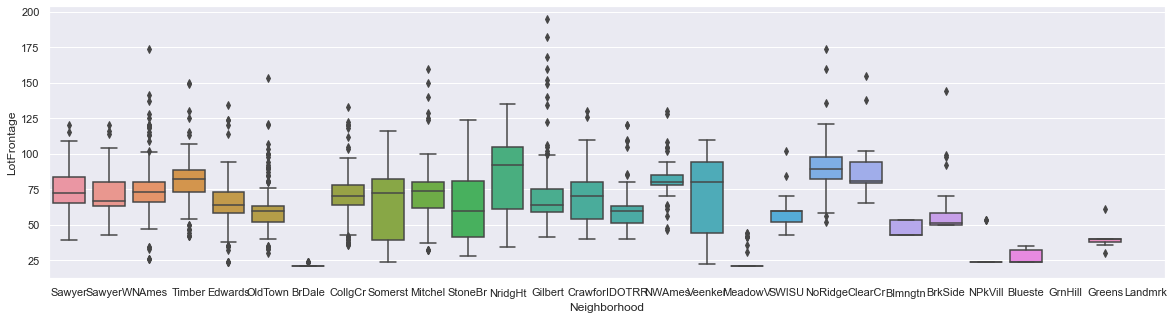

In [877]:
lf_df = pd.concat([big_df['Neighborhood'], big_df['LotFrontage']], axis=1)

plt.figure(figsize=(20,5))
sns.boxplot(x=big_df['Neighborhood'], y=big_df['LotFrontage'])

<AxesSubplot:xlabel='MSZoning', ylabel='LotFrontage'>

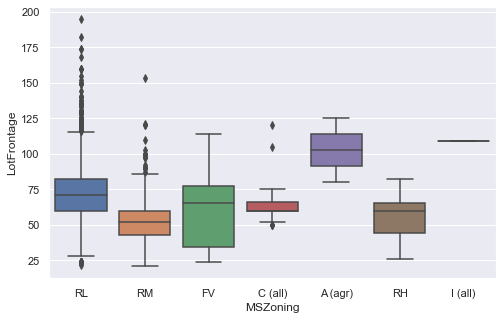

In [779]:
lf_df = pd.concat([big_df['MSZoning'], big_df['LotFrontage']], axis=1)

plt.figure(figsize=(8,5))
sns.boxplot(x=big_df['MSZoning'], y=big_df['LotFrontage'])

<AxesSubplot:xlabel='MSSubClass', ylabel='LotFrontage'>

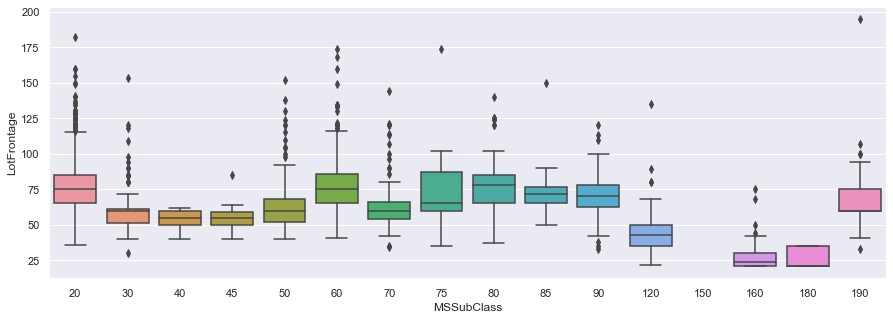

In [780]:
lf_df = pd.concat([big_df['MSSubClass'], big_df['LotFrontage']], axis=1)

plt.figure(figsize=(15,5))
sns.boxplot(x=big_df['MSSubClass'], y=big_df['LotFrontage'])

In [878]:
big_df['LotFrontage'] = big_df.groupby('MSSubClass')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [879]:
big_df.isnull().sum().sort_values(ascending=False)

SalePrice_norm    878
SalePrice         878
LotFrontage         1
TotalBsmtSF         0
BsmtQual            0
                 ... 
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
MSSubClass          0
Length: 74, dtype: int64

In [880]:
big_df['LotFrontage'] = big_df.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [881]:
big_df.isnull().sum().sort_values(ascending=False)

SalePrice_norm    878
SalePrice         878
TotalBsmtSF         0
Foundation          0
Exterior1st         0
                 ... 
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
MSSubClass          0
Length: 74, dtype: int64

In [882]:
big_df.shape

(2914, 74)

In [785]:
big_df['MSSubClass'] = big_df['MSSubClass'].astype(str)
big_df['MoSold'] = big_df['MoSold'].astype(str)
big_df['YrSold'] = big_df['YrSold'].astype(str)

In [786]:
big_df.to_csv('big_df_chk1.csv')

In [787]:
big_df = pd.read_csv('big_df_chk1.csv')
# Binarized Columns

big_df['YesPool'] = big_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
big_df['Yes2F'] = big_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
big_df['YesGarage'] = big_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
big_df['YesBsmt'] = big_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
big_df['YesFireplace'] = big_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [788]:
# simplifying some columns 


big_df['TotalLvgSF'] = big_df['TotalBsmtSF'] + big_df['GrLivArea']
big_df['TotalQuality'] = big_df['OverallQual'] + big_df['OverallCond']
big_df['TotalSF'] = big_df['BsmtFinSF1'] + big_df['BsmtFinSF2'] + big_df['1stFlrSF'] + big_df['2ndFlrSF']
big_df['TotalBath'] = big_df['FullBath'] + big_df['BsmtFullBath'] + 0.5*(big_df['HalfBath'] + big_df['BsmtHalfBath'])
big_df['TotalPorchSF'] = big_df['WoodDeckSF'] + big_df['OpenPorchSF'] + big_df['3SsnPorch'] + big_df['EnclosedPorch'] + big_df['ScreenPorch']

In [789]:
# adding some interactive columns
big_df['TotalLvgSF_Qual'] = big_df['TotalLvgSF']*big_df['TotalQuality'] 
big_df['TotalCondQual'] = big_df['OverallCond']*big_df['OverallQual']

In [790]:
numeric_col = big_df[big_df._get_numeric_data().columns]
numeric_col.columns

Index(['Unnamed: 0', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice_norm', 'YesPool',
       'Yes2F', 'YesGarage', 'YesBsmt', 'YesFireplace', 'TotalLvgSF',
       'TotalQuality', 'TotalSF', 'TotalBath', 'TotalPorchSF',
       'TotalLvgSF_Qual', 'TotalCondQual'],
      dtype='object')

In [791]:
skewed_list = []

for col in list(numeric_col.columns):

    skew = stats.skew(big_df[col])
    if skew > 0.5 or skew < -0.5:
        skewed_list.append(col)
    print(f'{col}:   skew:{skew}')

print(skewed_list)

Unnamed: 0:   skew:0.0
MSSubClass:   skew:1.3524258840016117
LotFrontage:   skew:0.5289383448624689
LotArea:   skew:14.459765542122382
OverallQual:   skew:0.18363115533677557
OverallCond:   skew:0.5722594714563014
YearBuilt:   skew:-0.6017000568055284
YearRemod/Add:   skew:-0.44797861863923083
MasVnrArea:   skew:2.6076686413858297
BsmtFinSF1:   skew:0.8327112732563352
BsmtFinSF2:   skew:4.113931479136624
BsmtUnfSF:   skew:0.921667666313335
TotalBsmtSF:   skew:0.34853132095657013
1stFlrSF:   skew:0.8058060406943611
2ndFlrSF:   skew:0.8588497847219794
LowQualFinSF:   skew:12.078202716583714
GrLivArea:   skew:0.9417624132100568
BsmtFullBath:   skew:0.6134872157984879
BsmtHalfBath:   skew:3.9567077602376535
FullBath:   skew:0.17236583301890707
HalfBath:   skew:0.6982257750130989
BedroomAbvGr:   skew:0.31582808179802124
KitchenAbvGr:   skew:4.2979924748771055
TotRmsAbvGrd:   skew:0.6996931234106242
Fireplaces:   skew:0.7368394957388151
GarageYrBlt:   skew:-3.902904890500826
GarageCars:   sk

In [792]:
# remove binary columns
skewed_list.remove('YesPool')

skewed_list.remove('YesBsmt')
skewed_list.remove('YesGarage')

In [793]:
def max_boxcox1p(df, col): 
    max_lambda = stats.boxcox_normmax(df[col]+1)
    df[col] = boxcox1p(df[col], max_lambda)
    return df[col]


for col in skewed_list:  
    max_boxcox1p(big_df, col)

/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/alyssiaoh/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3875: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [794]:
big_df.head()

Unnamed: 0  MSSubClass MSZoning  LotFrontage    LotArea LotShape  \
0           0    6.607841       RL    31.188031  20.774202      IR1   
1           1    6.607841       RL    20.450934  20.123055      IR1   
2           2    4.300278       RL    28.964221  18.688021      Reg   
3           3    6.607841       RL    30.558474  19.499814      Reg   
4           4    6.182485       RL    33.357589  20.985146      IR1   

  LandContour LotConfig LandSlope Neighborhood  ... YesGarage YesBsmt  \
0         Lvl   CulDSac       Gtl       Sawyer  ...         1       1   
1         Lvl   CulDSac       Gtl      SawyerW  ...         1       1   
2         Lvl    Inside       Gtl        NAmes  ...         1       1   
3         Lvl    Inside       Gtl       Timber  ...         1       1   
4         Lvl    Inside       Gtl      SawyerW  ...         1       1   

  YesFireplace TotalLvgSF  TotalQuality    TotalSF  TotalBath  TotalPorchSF  \
0            0  49.515469     71.648725  14.044537        2.5     16.011841   
1            1  56.463618     55.278932  15.037011        3.5     22.730004   
2            0  48.672520     55.278932  13.685267        2.0     17.932285   
3            0  45.839009     40.801625  13.050612        2.5     27.771664   
4            0  48.738857     71.648725  13.052636        2.0     19.526771   

  TotalLvgSF_Qual TotalCondQual  
0      136.565694            48  
1      145.741676            35  
2      126.454766            35  
3      111.153401            25  
4      134.523344            48  

[5 rows x 87 columns]

In [795]:
big_norm_df = big_df.copy()
big_norm_df.to_csv('big_norm_df.csv')

In [796]:
big_norm_df.drop(columns='Unnamed: 0', inplace=True)

In [797]:
big_norm_df.isnull().sum().sort_values(ascending=False)

SalePrice_norm    878
SalePrice         878
TotalCondQual       0
MasVnrArea          0
ExterQual           0
                 ... 
GarageCars          0
GarageArea          0
GarageQual          0
GarageCond          0
MSSubClass          0
Length: 86, dtype: int64

# Processing and modeling

## RidgeCV

In [888]:
X = big_norm_df.drop(columns=['SalePrice', 'SalePrice_norm'])
X.shape

(2914, 84)

In [889]:
X = pd.get_dummies(data=X, drop_first=True, columns=categorical_col)
categorical_col

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType']

In [900]:
X = pd.DataFrame(X)
Xtrain = X.iloc[:2036, :] 
Xtest = X.iloc[2036:, :]
y = big_norm_df['SalePrice_norm'].iloc[:2036]
X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size = .1, random_state = 42)
X_train.shape


(1832, 263)

In [891]:
kf = KFold(n_splits=20, random_state=42, shuffle=True)
r_alphas = np.logspace(0.000001, 5, 100)
ridge_pipe = Pipeline([('sc', StandardScaler()), ('ridgeCV', RidgeCV(alphas=r_alphas, cv=kf))])
ridge_pipe

Pipeline(steps=[('sc', StandardScaler()),
                ('ridgeCV',
                 RidgeCV(alphas=array([1.00000230e+00, 1.12332659e+00, 1.26185973e+00, 1.41747733e+00,
       1.59228631e+00, 1.78865344e+00, 2.00923735e+00, 2.25702455e+00,
       2.53536986e+00, 2.84804183e+00, 3.19927376e+00, 3.59382102e+00,
       4.03702543e+00, 4.53488758e+00, 5.09414809e+00, 5.72237884e+00,
       6.42808553e+00, 7.22082279e+00, 8.11132...
       1.09749925e+04, 1.23284726e+04, 1.38488692e+04, 1.55567672e+04,
       1.74752901e+04, 1.96304129e+04, 2.20513141e+04, 2.47707705e+04,
       2.78256011e+04, 3.12571658e+04, 3.51119247e+04, 3.94420679e+04,
       4.43062218e+04, 4.97702426e+04, 5.59081083e+04, 6.28029203e+04,
       7.05480280e+04, 7.92482935e+04, 8.90215106e+04, 1.00000000e+05]),
                         cv=KFold(n_splits=20, random_state=42, shuffle=True)))])

In [892]:
ridge_train = ridge_pipe.fit(X_train, y_train)
y_trainpred = ridge_pipe.predict(X_train)

In [893]:
# RMSE for training
mean_squared_error(y_train, (y_trainpred), squared=False)

0.09252712498010403

In [820]:
y_testpred = ridge_pipe.predict(X_test)

In [821]:
# RMSE for testing
mean_squared_error(y_test, y_testpred, squared=False)

0.17499902508196602

## LassoCV

In [809]:
lasso_pipe = Pipeline([('sc', StandardScaler()), ('lassoCV', LassoCV(alphas=r_alphas, cv=kf))])
lasso_pipe
lasso_train = lasso_pipe.fit(X_train, y_train)
y_trainpred = lasso_pipe.predict(X_train)
mean_squared_error(y_train, (y_trainpred), squared=False)

0.40190859557144093

In [810]:
y_testpred = lasso_pipe.predict(X_test)
mean_squared_error(y_test, y_testpred, squared=False)

0.474991103894473

# Preparing Sample submission

In [901]:
submission7 = pd.read_csv("datasets/submission_1.csv")
submission7.shape
Xtest.shape

(878, 263)

In [ ]:
submission7.iloc[:, 1] = np.expm1(ridge_pipe.predict(Xtest))

submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 50000 else x*1.3)
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x < 6500000 else x*1.075)

submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission7b.csv", index=False)

In [903]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 150000 else x*1.05)
submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission7a.csv", index=False)

In [903]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 1500000 else x*1.05)
submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission8.csv", index=False)

In [903]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 60000 else x*1.25)
submission7.to_csv("submission9.csv", index=False)

In [903]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 150000 else x*1.05)
submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission1.csv", index=False)

In [903]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 150000 else x*1.05)
submission7['SalePrice'] *= 1.00175
submission7.to_csv("submission2.csv", index=False)

In [903]:
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x > 60000 else x*1.3)
submission7['SalePrice'] = submission7['SalePrice'].apply(lambda x: x if x < 6000000 else x*1.075)submission7['SalePrice'] *= 1.0015
submission7.to_csv("submission3.csv", index=False)

# Conclusion


- How can be best predict the housing prices by deep-cleaning our data? 

1. eliminate outliers
2. combining interrelated features to simply the model
3. transform the data to follow standard distribution 
